<a href="https://colab.research.google.com/github/gavinkress/EHHOP-ED-Project/blob/master/Live_Copy_of_Main_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<div class="alert alert-block alert-info">
 <b style="font-size:300%;"> Icahn School of Medicine at Mount Sinai</b><br>
 <b style="font-size:200%;">EHHOP Emergency Analysis Project</b>
</div>

<div class="alert alert-block alert-success" style = "color:black">
<p><b>Last Update: </b>6/30/2024</p>
<p><b>Authors:</b> Gavin Kress and Hailey Yettman</p>
<b>Inquiries:</b>
    <ul>
      <li><a href="mailto:gavin.kress@icahn.mssm.edu">gavin.kress@icahn.mssm.edu</a></li>
      <li><a href="mailto:hailey.yetman@icahn.mssm.edu">hailey.yetman@icahn.mssm.edu</a></li>
    </ul>  

</div>


# Package Handling

In [1]:
#Install needed packages
!pip install pandas;
!pip install matplotlib;
!pip install seaborn;
!pip install matplotlib.pyplot as plt;
!pip install scipy;
!pip install scikit-learn


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random
from matplotlib.lines import Line2D


# Load Data


In [2]:
#import the local version of the Excel file
uploaded = files.upload()

Saving EHHOP ED Usage Data Collection.xlsx to EHHOP ED Usage Data Collection.xlsx


In [156]:

# Save Data to Pd frame
Collected_Data = pd.read_excel('EHHOP ED Usage Data Collection.xlsx')

Res_Eval1 = pd.read_excel('EHHOP ED Usage Data Collection.xlsx', sheet_name = 'Resident Eval - Neha')

Res_Eval2 = pd.read_excel('EHHOP ED Usage Data Collection.xlsx', sheet_name = 'Resident Eval - Terence')

Linking = pd.read_excel('EHHOP ED Usage Data Collection.xlsx', sheet_name = 'Linking Key')

#Binary code sex
Collected_Data['Patient Sex'] = Collected_Data['Patient Sex'].replace({'M': 0, 'F': 1})

#Link Resident Evals
#link to MRN on Linking Key

Collected_Data = Collected_Data.merge(Linking,how='outer', left_index=True, right_index=True)

#Merge Resident Evals
Collected_Data = Collected_Data.merge(Res_Eval1[['MRN','Was this visit avoidable?',
       'Why was this visit avoidable?',
       'Was there any advanced imaging done at this visit?',
       'Any procedures during this visit?', 'Any STAT labs during this visit?',
       'Any consults during this visit?',
       'If admitted, what team were they admitted to?',
       'Were they admitted to the ICU?', 'Were they admitted to the OR?',
       'AMA/LWBS (Yes/No)', 'Note (Other)']].add_suffix('_1'), how='outer', left_index=True, right_index=True)
Collected_Data = Collected_Data.merge(Res_Eval1[['MRN','Was this visit avoidable?',
       'Why was this visit avoidable?',
       'Was there any advanced imaging done at this visit?',
       'Any procedures during this visit?', 'Any STAT labs during this visit?',
       'Any consults during this visit?',
       'If admitted, what team were they admitted to?',
       'Were they admitted to the ICU?', 'Were they admitted to the OR?',
       'AMA/LWBS (Yes/No)', 'Note (Other)']].add_suffix('_2'), how='outer', left_index=True, right_index=True)


#first create column with number of ED visits
Collected_Data['ED Visits'] =0
for i in Collected_Data['Unnamed: 0'].unique():
  if Collected_Data.loc[Collected_Data['Unnamed: 0']==i,:].__len__() > 1:
    Collected_Data.loc[Collected_Data['Unnamed: 0']==i,'ED Visits'] = Collected_Data.loc[Collected_Data['Unnamed: 0']==i].__len__()
  elif ((Collected_Data.loc[Collected_Data['Unnamed: 0']==i].__len__() == 1) and (list((Collected_Data.loc[Collected_Data['Unnamed: 0']==i,'Did Patient X utilize the ED in the past year?'] == 1))[0])):
    Collected_Data.loc[Collected_Data['Unnamed: 0']==i,'ED Visits'] = 1

#Create Dataframe with first ER visits only (unique patients)
Collected_Data_u = pd.DataFrame(Collected_Data.groupby('Unnamed: 0').first())



# Part A: Questions Investigated Using Maisy's Data Set:


## 1. Are any particular co-morbidities predictive of EHHOP patient ED utilization? and
## 2. Are any particular demographic factors predictive of EHHOP patient ED utilization?



### Counts of Comorbisities (and Sex) and ED Visits

In [17]:
# List of Comorbidity feilds also added sex since its the same workflow - age will follow

Comorbs = ['Does this patient have hypertension?','Does this patient have diabetes?','Does this patient have chronic liver, lung or kidney disease?','Does this patient use tobacco?','Does this patient have AUD?','Does this patient have an autoimmune disease?','Does this patient experience food insecurity?','Does this patient have anxiety or depression?', 'Patient Sex']

#Show Value Counts of Cormorbidities and ED visits
for c in Comorbs:
  print(Collected_Data[['Did Patient X utilize the ED in the past year?',c]].value_counts())

Did Patient X utilize the ED in the past year?  Does this patient have hypertension?
1.0                                             0                                       89
0.0                                             0                                       68
1.0                                             1                                       60
0.0                                             1                                       34
Name: count, dtype: int64
Did Patient X utilize the ED in the past year?  Does this patient have diabetes?
1.0                                             0                                   91
0.0                                             0                                   73
1.0                                             1                                   58
0.0                                             1                                   29
Name: count, dtype: int64
Did Patient X utilize the ED in the past year?  Does this patient have

### Relative Risk Odds Ratios, and Chi^2

In [19]:
# Calculate the Relative Risk, Odds Ratio, and Perform a Chi^2
ED_s = 'Did Patient X utilize the ED in the past year?' # so we don't need to type this out each time

## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = Comorbs)

for com in Comorbs:
  v_cnts = Collected_Data[[ED_s, com]].value_counts() #ED State, #Comorbididty State

  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]+v_cnts.loc[(1,1)], v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]+v_cnts.loc[(0,1)])
  R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]], [v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]]])
  R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (v_cnts.loc[(1,1)]+ v_cnts.loc[(1,0)])/v_cnts.sum()
  f_exp1 = (np.array([(v_cnts.loc[(0,0)]+v_cnts.loc[(1,0)]), (v_cnts.loc[(0,1)]+v_cnts.loc[(1,1)])])*ED_prob)
  f_obs1= np.array([v_cnts.loc[(1,0)], v_cnts.loc[(1,1)]])
  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

print(R_DF)

                                                   p (Chi^2)  \
Does this patient have hypertension?                   0.477   
Does this patient have diabetes?                       0.274   
Does this patient have chronic liver, lung or k...     0.181   
Does this patient use tobacco?                         0.344   
Does this patient have AUD?                            0.007   
Does this patient have an autoimmune disease?          0.055   
Does this patient experience food insecurity?          0.199   
Does this patient have anxiety or depression?          0.011   
Patient Sex                                            0.942   

                                                            Relative Risk  \
Does this patient have hypertension?                 1.21 [ 0.86 - 1.69 ]   
Does this patient have diabetes?                     1.37 [ 0.95 - 1.98 ]   
Does this patient have chronic liver, lung or k...   1.55 [ 1.02 - 2.36 ]   
Does this patient use tobacco?                     

✅ Yes, alchohol use disorder and anxiety/dep are individually predictive of ER use.

### T-test and ROC-AUC for Age

---------------------------------------
---------------------------------------
AUC mean = 0.5059796747967479, AUC std = 0.055326160365191085, p = 0.2524428361830103
---------------------------------------
---------------------------------------


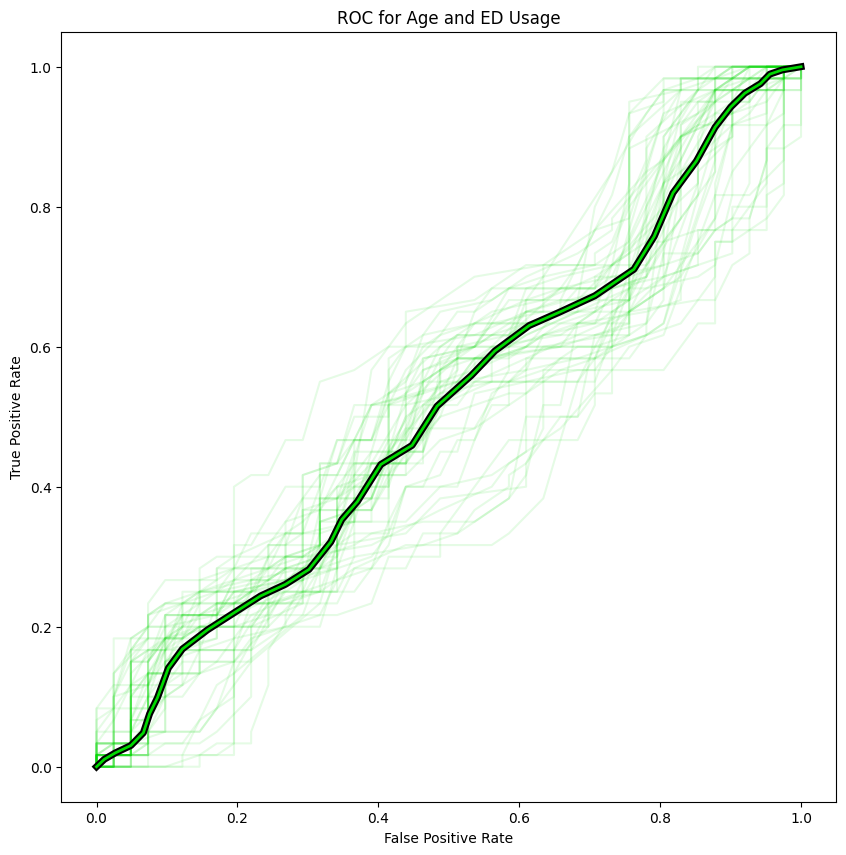

In [20]:
#AUC ROC
p = scipy.stats.ttest_ind(Collected_Data.loc[Collected_Data[ED_s]==0, 'Patient Age'].astype(float), Collected_Data.loc[Collected_Data[ED_s]==1, 'Patient Age'].astype(float), alternative = 'two-sided', nan_policy='omit')[1]

def tt_split(x, y, train_size):
    if np.shape(x) == np.shape(y):
        uniques = np.unique(y, return_counts=True)
        tr = []
        for ct, u in enumerate(uniques[0]):
            inds = list(np.argwhere(y == u).flatten())
            tr = tr + random.sample(inds, int(train_size * float(len(inds))))

        tr = np.array(tr).flatten()
        te = [aa for aa in range(0, len(x)) if aa not in tr]
        return x[tr], x[te], y[tr], y[te]
    else:
        print('shape not the same')
        return -1

# Log Reg
rs_n = 2
ts = 0.6
kf = 50

lr_auc_list = []
fp_list1 = []
tp_list1 = []
DF_s = Collected_Data.dropna(axis=0, subset=[ED_s, 'Patient Age'])

for i in range(kf):
  y = np.array(DF_s[ED_s].astype(int))
  X = np.array(DF_s['Patient Age'])
  trainX, testX, trainy, testy = tt_split(X, y, train_size=ts)
  model = LogisticRegression(solver='lbfgs')
  model.fit(np.array(trainX).reshape(-1,1), np.array(trainy))
  lr_probs = model.predict_proba(np.array(testX).reshape(-1,1))
  lr_probs = lr_probs[:, 1]
  lr_auc = roc_auc_score(testy, lr_probs)
  fpr, tpr, thresholds = roc_curve(testy, lr_probs, pos_label=1, drop_intermediate=False)
  lr_auc_list.append(lr_auc)

  plt.figure(1, figsize=(10, 10))
  plt.plot(fpr, tpr, color= (0, 0.85, 0, 0.1))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for Age and ED Usage')


  fp_list1.append(fpr)
  tp_list1.append(tpr)

meann = np.array(lr_auc_list).mean()
std = np.array(lr_auc_list).std()

tp_list1 = [x for x in tp_list1 if len(x) == int(scipy.stats.mode([len(x) for x in tp_list1])[0])]
fp_list1 = [x for x in fp_list1 if len(x) == int(scipy.stats.mode([len(x) for x in fp_list1])[0])]
tp_m = np.stack(tp_list1).mean(axis = 0)
fp_m = np.stack(fp_list1).mean(axis=0)

plt.figure(1)
plt.plot(fp_m, tp_m, color=(0, 0.85, 0, 1), lw = 2, zorder = 1502)
plt.plot(fp_m, tp_m, color='k', lw = 5, zorder=1501)
print('---------------------------------------')
print('---------------------------------------')
print('AUC mean = ' + str(meann) + ', AUC std = ' + str(std) + ', p = ' + str(p))
print('---------------------------------------')
print('---------------------------------------')

#custom_lines = [Line2D([0], [0], color=c_list_m[x], lw=4) for x in scoresp]
#plt.legend(handles = custom_lines, labels = scoresp)
plt.show()





✅ Not for age.

## 3. Are any subgroups of co-morbidities additively predictive of EHHOP patient ED utilization?

 ### Show all occurances of combinations of comorbidies for ED = 0 then ED = 1

In [21]:
#Show Value Counts of All occuring cormorbidity combinations and ED visits
Comorbs = ['Does this patient have hypertension?','Does this patient have diabetes?' ,'Does this patient have chronic liver, lung or kidney disease?','Does this patient use tobacco?','Does this patient have AUD?','Does this patient have an autoimmune disease?','Does this patient experience food insecurity?','Does this patient have anxiety or depression?'] #without sex

#Value counts to Dataframe
df1 = pd.DataFrame(Collected_Data[Collected_Data['Did the patient contact EHHOP about going to the ED?']==0][Comorbs].value_counts())
df1[ED_s]=0
df2 = pd.DataFrame(Collected_Data[Collected_Data['Did the patient contact EHHOP about going to the ED?']==1][Comorbs].value_counts())
df2[ED_s]=1
df = pd.concat([df1, df2])
print(df)

                                                                                                                                                                                                                                                                                                                               count  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression?          
0                                    0                                0                                                  0                              0                           1                                             0                                             0                                                 12   
                

### Relative Risk Odds Ratios, and Chi^2


In [23]:
## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = df.index)

for i in df.index:
  #get counts
  #ED = yes, combo=yes
  n11 = list(df.loc[(df[ED_s]==1) & (df.index==i), 'count'])
  if len(n11) == 0:
    n11 = 0
  else:
    n11 = n11[0]
  #ED = no, combo=yes
  n01 = list(df.loc[(df[ED_s]==0) & (df.index==i), 'count'])
  if len(n01) == 0:
    n01 = 0
  else:
    n01 = n01[0]
  #ED = yes, combo=no
  n10 = df.loc[(df[ED_s]==1) & (df.index!=i), 'count'].sum()
  #ED = no, combo=no
  n00 = df.loc[(df[ED_s]==0) & (df.index!=i), 'count'].sum()


  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(n11, n10+n11, n01, n00+n01)
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'


  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[n11, n10], [n01, n00]])
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (n11+ n10)/(n00+n01+n10+n11)
  f_exp1 = (np.array([(n00+n10), (n01+n11)])*ED_prob)
  f_obs1= np.array([n10, n11])

  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))

#drop all wil

print(R_DF)

<ipython-input-23-de2cbea67e7e>:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-23-de2cbea67e7e>:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-23-de2cbea67e7e>:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))


                                                                                                                                                                                                                                                                                                                              p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression?             
0                                    0                                0                                                  0                              0                           1                                             0                                             0                                                 0.156   
       

✅ It seems so but lets look at the combos that might be without so much clutter to be more sure.

### Display only combos with p<0.05 or OR/RR>2

In [35]:
R_DF.loc[(R_DF['p (Chi^2)'].astype(float)  < 0.05)|(R_DF['Odds Ratio'].str.split(' \[').str[0].astype(float) > 2)|(R_DF['Relative Risk'].str.split(' \[').str[0].astype(float) > 2)]

p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression?             
0                                    0                                0                                                  0                              0                           0                                             0                                             0                                                 0.102   
1                                    1                                1                                                  0                              1                           0                                             1                                             1                                                 0.157   
0                                    0                                0                                                  0                              0                           0                                             1                                             1                                                 0.075   
1                                    1                                1                                                  0                              0                           0                                             0                                             0                                                 0.075   
                                     0                                0                                                  0                              0                           1                                             1                                             1                                                 0.212   
0                                    0                                0                                                  0                              0                           0                                             0                                             0                                                 0.102   
1                                    1                                1                                                  0                              0                           0                                             0                                             0                                                 0.075   
                                                                                                                                                        1                           0                                             1                                             1                                                 0.157   
0                                    0                                0                                                  0                              0                           0                                             1                                             1                                                 0.075   
                                     1                                0                                                  0                              0                           0                                             1                                             1                                                 0.031   
                                                                      1                                                  0                              1                           0                                             0                                             1                                                 0.031   
1              

✅ I would say probably so but its up for interpretation if there is enough power to make the argument statistically

## 4. Are the average numbers of co-morbidities different between the EHHOP patient groups that use the ED and those who did not?

### T-test and ROC-AUC for Number of Comorbidities

---------------------------------------
---------------------------------------
AUC mean = 0.6568617886178862, AUC std = 0.049621785880276895, p = 0.00010381557291982212, No ED Visit Comorbidity Sum Mean (std) = 1.4752475247524752 (1.2295857790812366), ED Visit Comorbidity Sum Mean (std) = 2.27027027027027 (1.407390447302677)
---------------------------------------
---------------------------------------


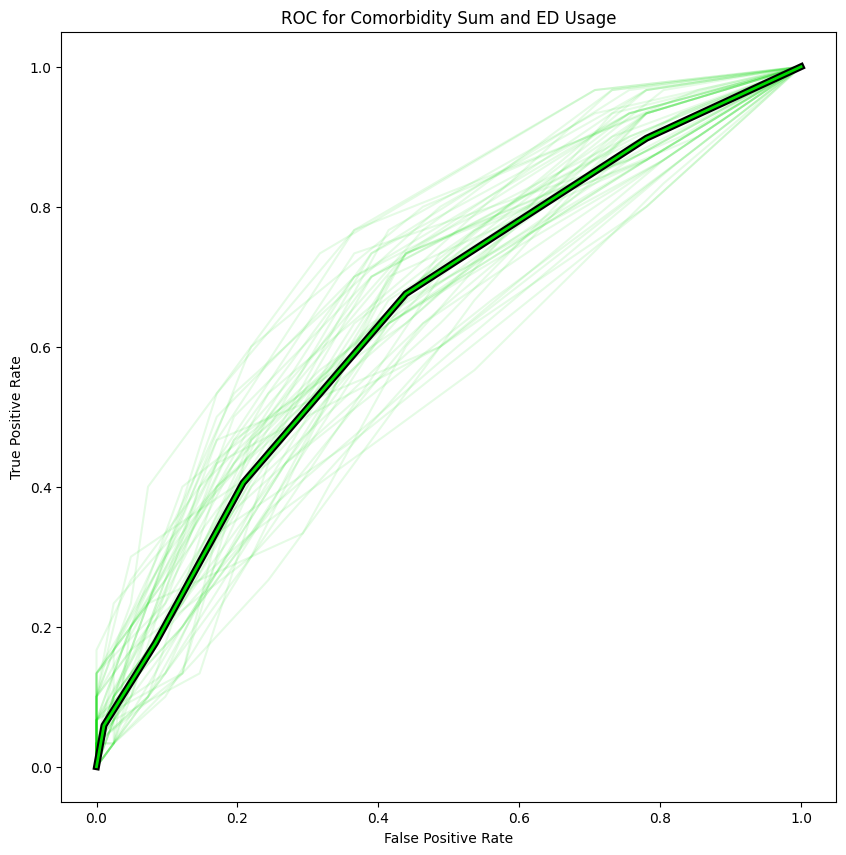

In [118]:
Collected_Data['Comorbidity Sum'] = Collected_Data[Comorbs].sum(axis=1)
Collected_Data_u['Comorbidity Sum'] = Collected_Data_u[Comorbs].sum(axis=1)
Collected_Data_original = Collected_Data.copy()
Collected_Data = Collected_Data_u.copy()

Outcome = 'Comorbidity Sum'

#AUC ROC
p = scipy.stats.ttest_ind(Collected_Data.loc[Collected_Data[ED_s]==0, Outcome].astype(float), Collected_Data.loc[Collected_Data[ED_s]==1, Outcome].astype(float), alternative = 'two-sided', nan_policy='omit')[1]

def tt_split(x, y, train_size):
    if np.shape(x) == np.shape(y):
        uniques = np.unique(y, return_counts=True)
        tr = []
        for ct, u in enumerate(uniques[0]):
            inds = list(np.argwhere(y == u).flatten())
            tr = tr + random.sample(inds, int(train_size * float(len(inds))))

        tr = np.array(tr).flatten()
        te = [aa for aa in range(0, len(x)) if aa not in tr]
        return x[tr], x[te], y[tr], y[te]
    else:
        print('shape not the same')
        return -1

# Log Reg
rs_n = 2
ts = 0.6
kf = 50

lr_auc_list = []
fp_list1 = []
tp_list1 = []
DF_s = Collected_Data.dropna(axis=0, subset=[ED_s, Outcome])

for i in range(kf):
  y = np.array(DF_s[ED_s].astype(int))
  X = np.array(DF_s[Outcome])

  trainX, testX, trainy, testy = tt_split(X, y, train_size=ts)
  model = LogisticRegression(solver='lbfgs')
  model.fit(np.array(trainX).reshape(-1,1), np.array(trainy))
  lr_probs = model.predict_proba(np.array(testX).reshape(-1,1))
  lr_probs = lr_probs[:, 1]
  lr_auc = roc_auc_score(testy, lr_probs)
  fpr, tpr, thresholds = roc_curve(testy, lr_probs, pos_label=1, drop_intermediate=False)
  lr_auc_list.append(lr_auc)

  plt.figure(1, figsize=(10, 10))
  plt.plot(fpr, tpr, color= (0, 0.85, 0, 0.1))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for ' + Outcome + ' and ED Usage')


  fp_list1.append(fpr)
  tp_list1.append(tpr)

meann = np.array(lr_auc_list).mean()
std = np.array(lr_auc_list).std()

tp_list1 = [x for x in tp_list1 if len(x) == int(scipy.stats.mode([len(x) for x in tp_list1])[0])]
fp_list1 = [x for x in fp_list1 if len(x) == int(scipy.stats.mode([len(x) for x in fp_list1])[0])]
tp_m = np.stack(tp_list1).mean(axis = 0)
fp_m = np.stack(fp_list1).mean(axis=0)

plt.figure(1)
plt.plot(fp_m, tp_m, color=(0, 0.85, 0, 1), lw = 2, zorder = 1502)
plt.plot(fp_m, tp_m, color='k', lw = 5, zorder=1501)
print('---------------------------------------')
print('---------------------------------------')
print('AUC mean = ' + str(meann) + ', AUC std = ' + str(std) + ', p = ' + str(p) + ', No ED Visit ' + Outcome + ' Mean (std) = '+ str(Collected_Data.loc[Collected_Data[ED_s]==0,Outcome].mean()) + ' (' + str(Collected_Data.loc[Collected_Data[ED_s]==0,Outcome].std()) + ')'+', ED Visit ' + Outcome + ' Mean (std) = '+ str(Collected_Data.loc[Collected_Data[ED_s]==1,Outcome].mean()) + ' (' + str(Collected_Data.loc[Collected_Data[ED_s]==1,Outcome].std()) + ')')
print('---------------------------------------')
print('---------------------------------------')

#custom_lines = [Line2D([0], [0], color=c_list_m[x], lw=4) for x in scoresp]
#plt.legend(handles = custom_lines, labels = scoresp)
plt.show()



Collected_Data = Collected_Data_original.copy()



✅ Yes, very much so, note this analysis was done treating each patient as a sample point while the previouse analyses were done treating each ED visit as a data point

## 5. How many patients are calling EHHOP before using the ED?

In [119]:
VCs = Collected_Data_u.loc[(Collected_Data_u[ED_s]==1), 'Did the patient contact EHHOP about going to the ED?'].value_counts()
print(str(round(VCs[1]/VCs.sum(),2)*100) + '% ('+str(VCs[1]) + '/' + str(VCs.sum()) +') of patients calling EHHOP before using the ED')

19.0% (14/74) of patients calling EHHOP before using the ED


✅ 19% (14/74) Patients

## 6. How many patients are getting called back by EHHOP before using the ED?

In [120]:
VCs = Collected_Data.loc[(Collected_Data[ED_s]==1)&(Collected_Data['Did the patient contact EHHOP about going to the ED?']==1),'Did they recieve a call back from an EHHOP?'].value_counts()
print(str(round(VCs[1]/VCs.sum(),2)*100) + '% ('+str(VCs[1]) + '/' + str(VCs.sum()) +') of calls got returned')

100.0% (22/22) of calls got returned


✅ 100%

## 7. How do our patient’s ED utilization rates compare to the national averages in semi-comparable groups?

In [122]:
VCs = Collected_Data_u[ED_s].value_counts()
print(str(round(VCs[1]/VCs.sum(),2)*100) + '% ('+str(VCs[1]) + '/' + str(VCs.sum()) +') of EHHOP patients used the ED in the past year compared to 33.36% in the general US Latino population - (33.04% for uninsured)')
print('-')

VCs = Collected_Data.loc[Collected_Data[ED_s]==1,['ESI 1', 'ESI 2', 'ESI 3', 'ESI 4', 'ESI 5']].sum()
VCs['no ESI']= Collected_Data[ED_s].value_counts()[1]-VCs.sum()
Collected_Data.loc[Collected_Data[ED_s]==1,['ESI 1', 'ESI 2', 'ESI 3', 'ESI 4', 'ESI 5']].value_counts()
for i in VCs.index:
  print(str(round(VCs[i]/VCs.sum(),2)*100) + '% ('+str(VCs[i]) + '/' + str(VCs.sum()) +') EHHOP patients ED visits in the past year were classified as ' + i)
  print('-')

print('Thus ' + str(round(VCs[2:].sum()/VCs.sum(),2)*100) + '% ('+str(VCs[2:].sum()) + '/' + str(VCs.sum()) +') of visits were ESI 3-5 or no ESI compared to 60% of visits for those in the general US Latino population (same for uninsured)')
print('-')
print('Thus ' + str(round(VCs[:2].sum()/VCs.sum(),2)*100) + '% ('+str(VCs[:2].sum()) + '/' + str(VCs.sum()) +') of visits were ESI 1-2 compared to 10% of visits for those in the general US Latino population (9% for uninsured)')
print('-')
print('100% of EHHOP patients were Latino')



42.0% (74/175) of EHHOP patients used the ED in the past year compared to 33.36% in the general US Latino population - (33.04% for uninsured)
-
0.0% (0.0/149.0) EHHOP patients ED visits in the past year were classified as ESI 1
-
12.0% (18.0/149.0) EHHOP patients ED visits in the past year were classified as ESI 2
-
40.0% (60.0/149.0) EHHOP patients ED visits in the past year were classified as ESI 3
-
17.0% (25.0/149.0) EHHOP patients ED visits in the past year were classified as ESI 4
-
0.0% (0.0/149.0) EHHOP patients ED visits in the past year were classified as ESI 5
-
31.0% (46.0/149.0) EHHOP patients ED visits in the past year were classified as no ESI
-
Thus 88.0% (131.0/149.0) of visits were ESI 3-5 or no ESI compared to 60% of visits for those in the general US Latino population (same for uninsured)
-
Thus 12.0% (18.0/149.0) of visits were ESI 1-2 compared to 10% of visits for those in the general US Latino population (9% for uninsured)
-
100% of EHHOP patients were Latino


# Part B: Questions Investigated Using The Residents' Data Set:


## 1. Were patients enrolled in the CCS program at EHHOP protected from avoidable ED visits?

## Show value counts of ED Visits and both residents' evaluations

In [123]:

Collected_Data.loc[:,['Chronic Care Senior?', ED_s, 'Was this visit avoidable?_1','Was this visit avoidable?_2']].value_counts()

Chronic Care Senior?  Did Patient X utilize the ED in the past year?  Was this visit avoidable?_1  Was this visit avoidable?_2
1.0                   1.0                                             No                           No                             34
0.0                   0.0                                             No                           No                             30
1.0                   0.0                                             No                           No                             22
0.0                   1.0                                             No                           No                             19
1.0                   1.0                                             Yes                          Yes                            18
0.0                   0.0                                             Yes                          Yes                            15
1.0                   0.0                                             Yes  

Since the residents alwyas agreed, only one analysis is necessary

## First, check if they differed in number of ED visits with Chi^2, OR, RR then if those who did differed in the porportion that were avoidable, in the same way

In [132]:
# Calculate the Relative Risk, Odds Ratio, and Perform a Chi^2
com = 'Chronic Care Senior?'

## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = [com])



v_cnts = Collected_Data[[ED_s, com]].value_counts() #ED State, #CCS

#Relative Risk
rr = scipy.stats.contingency.relative_risk(v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]+v_cnts.loc[(1,1)], v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]+v_cnts.loc[(0,1)])
R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

#Odds Ratio
oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]], [v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]]])
R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

#Chi^2
ED_prob = (v_cnts.loc[(1,1)]+ v_cnts.loc[(1,0)])/v_cnts.sum()
f_exp1 = (np.array([(v_cnts.loc[(0,0)]+v_cnts.loc[(1,0)]), (v_cnts.loc[(0,1)]+v_cnts.loc[(1,1)])])*ED_prob)
f_obs1= np.array([v_cnts.loc[(1,0)], v_cnts.loc[(1,1)]])
chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

R_DF.rename({com:'ED Visits'},inplace=True)
print(R_DF)


## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = [com])



v_cnts = Collected_Data.loc[Collected_Data[ED_s]==1,['Was this visit avoidable?_1', com]].value_counts() #Avoidable State, #CCS

#Relative Risk
rr = scipy.stats.contingency.relative_risk(v_cnts.loc[('Yes',1)], v_cnts.loc[('Yes',0)]+v_cnts.loc[('Yes',1)], v_cnts.loc[('No',1)], v_cnts.loc[('No',0)]+v_cnts.loc[('No',1)])
R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

#Odds Ratio
oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[('Yes',1)], v_cnts.loc[('Yes',0)]], [v_cnts.loc[('No',1)], v_cnts.loc[('No',0)]]])
R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

#Chi^2
ED_Av_prob = (v_cnts.loc[('Yes',1)]+ v_cnts.loc[('Yes',0)])/v_cnts.sum()
f_exp1 = (np.array([(v_cnts.loc[('No',0)]+v_cnts.loc[('Yes',0)]), (v_cnts.loc[('No',1)]+v_cnts.loc[('Yes',1)])])*ED_Av_prob)
f_obs1= np.array([v_cnts.loc[('Yes',0)], v_cnts.loc[('Yes',1)]])
chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

R_DF.rename({com:'Avoidable ED Visits'},inplace=True)
print('-')
print(R_DF)



          p (Chi^2)        Relative Risk           Odds Ratio
ED Visits     0.013  1.6 [ 1.23 - 2.07 ]  2.77 [ 1.6 - 4.85 ]
-
                    p (Chi^2)         Relative Risk            Odds Ratio
Avoidable ED Visits     0.122  1.34 [ 1.02 - 1.74 ]  3.3 [ 0.81 - 19.75 ]


✅ Unfortunately it looks like CCS patients were more likely to visit the ER and while the effect wasn't significant the relative risk of having avoidable ER risks seems higher.

## 2. Were certain particular comorbidities predictive of unavoidable ED visits? 4. Were certain particular co-morbidities predictive of avoidable 6. Was calling EHHOP before using the ED predictive of unavoidable ED visits?ED visits?


Adding the question about contacting EHHOP to the comorbidity list since it is the same workflow

In [207]:
Comorbs = ['Does this patient have hypertension?','Does this patient have diabetes?' ,'Does this patient have chronic liver, lung or kidney disease?','Does this patient use tobacco?','Does this patient have AUD?','Does this patient have an autoimmune disease?','Does this patient experience food insecurity?','Does this patient have anxiety or depression?', 'Did the patient contact EHHOP about going to the ED?']

### Relative Risk Odds Ratios, and Chi^2 for whether or not a visit was avoidable/unavoidable

In [217]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [209]:
# Calculate the Relative Risk, Odds Ratio, and Perform a Chi^2
 # so we don't need to type this out each time
#Reformate DF to make above code reusable
Collected_Data = Collected_Data.loc[Collected_Data[ED_s]==1,:]
ED_s = 'Was this visit avoidable?_1' # so we don't need to type this out each time

#Binary Code Avoidable
Collected_Data.loc[:,ED_s] = Collected_Data[ED_s].replace({'No': 0, 'Yes': 1})


## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = Comorbs)

for com in Comorbs:
  v_cnts = Collected_Data[[ED_s, com]].value_counts() #ED State, #Comorbididty State
  missing = [x for x in [(0,0),(0,1),(1,0),(1,1)] if x not in v_cnts.keys()]
  if len(missing)>0:
    for m in missing:
      v_cnts[m] = 0

  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]+v_cnts.loc[(1,1)], v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]+v_cnts.loc[(0,1)])
  R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]], [v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]]])
  R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (v_cnts.loc[(1,1)]+ v_cnts.loc[(1,0)])/v_cnts.sum()
  f_exp1 = (np.array([(v_cnts.loc[(0,0)]+v_cnts.loc[(1,0)]), (v_cnts.loc[(0,1)]+v_cnts.loc[(1,1)])])*ED_prob)
  f_obs1= np.array([v_cnts.loc[(1,0)], v_cnts.loc[(1,1)]])
  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

print(R_DF)

                                                   p (Chi^2)  \
Does this patient have hypertension?                   0.634   
Does this patient have diabetes?                       0.614   
Does this patient have chronic liver, lung or k...     0.381   
Does this patient use tobacco?                           nan   
Does this patient have AUD?                            0.273   
Does this patient have an autoimmune disease?          0.487   
Does this patient experience food insecurity?           0.33   
Does this patient have anxiety or depression?           0.33   
Did the patient contact EHHOP about going to th...     0.333   

                                                           Relative Risk  \
Does this patient have hypertension?                0.84 [ 0.45 - 1.56 ]   
Does this patient have diabetes?                     0.8 [ 0.37 - 1.71 ]   
Does this patient have chronic liver, lung or k...  0.69 [ 0.33 - 1.45 ]   
Does this patient use tobacco?                         

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:8064: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


✅ Nothing is significant.

In [210]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

### Relative Risk Odds Ratios, and Chi^2 for the occurance of an avoidable ER visit

In [211]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [212]:
# Calculate the Relative Risk, Odds Ratio, and Perform a Chi^2
 # so we don't need to type this out each time
#Reformate DF to make above code reusable
ED_s = 'Was this visit avoidable?_1' # so we don't need to type this out each time

#Binary Code Avoidable
Collected_Data.loc[:,ED_s] = Collected_Data[ED_s].replace({'No': 0, 'Yes': 1, np.nan: 0})


## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = Comorbs)

for com in Comorbs:
  v_cnts = Collected_Data[[ED_s, com]].value_counts() #ED State, #Comorbididty State
  missing = [x for x in [(0,0),(0,1),(1,0),(1,1)] if x not in v_cnts.keys()]
  if len(missing)>0:
    for m in missing:
      v_cnts[m] = 0

  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]+v_cnts.loc[(1,1)], v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]+v_cnts.loc[(0,1)])
  R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]], [v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]]])
  R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (v_cnts.loc[(1,1)]+ v_cnts.loc[(1,0)])/v_cnts.sum()
  f_exp1 = (np.array([(v_cnts.loc[(0,0)]+v_cnts.loc[(1,0)]), (v_cnts.loc[(0,1)]+v_cnts.loc[(1,1)])])*ED_prob)
  f_obs1= np.array([v_cnts.loc[(1,0)], v_cnts.loc[(1,1)]])
  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

print(R_DF)

                                                   p (Chi^2)  \
Does this patient have hypertension?                   0.311   
Does this patient have diabetes?                        0.67   
Does this patient have chronic liver, lung or k...     0.419   
Does this patient use tobacco?                         0.391   
Does this patient have AUD?                            0.022   
Does this patient have an autoimmune disease?          0.056   
Does this patient experience food insecurity?          0.748   
Does this patient have anxiety or depression?          0.567   
Did the patient contact EHHOP about going to th...     0.333   

                                                           Relative Risk  \
Does this patient have hypertension?                1.25 [ 0.86 - 1.83 ]   
Does this patient have diabetes?                    1.11 [ 0.73 - 1.69 ]   
Does this patient have chronic liver, lung or k...  0.78 [ 0.45 - 1.36 ]   
Does this patient use tobacco?                      0.5

✅ Yes, AUD and almost autoimmune disease.

In [213]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

### Relative Risk Odds Ratios, and Chi^2 for the occurance of an unavoidable ER visit

In [214]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [215]:
# Calculate the Relative Risk, Odds Ratio, and Perform a Chi^2
 # so we don't need to type this out each time
#Reformate DF to make above code reusable
ED_s = 'Was this visit avoidable?_1' # so we don't need to type this out each time

#Binary Code Unvoidable
Collected_Data.loc[:,ED_s] = Collected_Data[ED_s].replace({'No': 1, 'Yes': 0, np.nan: 0})


## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = Comorbs)

for com in Comorbs:
  v_cnts = Collected_Data[[ED_s, com]].value_counts() #ED State, #Comorbididty State
  missing = [x for x in [(0,0),(0,1),(1,0),(1,1)] if x not in v_cnts.keys()]
  if len(missing)>0:
    for m in missing:
      v_cnts[m] = 0

  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]+v_cnts.loc[(1,1)], v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]+v_cnts.loc[(0,1)])
  R_DF.loc[com, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[v_cnts.loc[(1,1)], v_cnts.loc[(1,0)]], [v_cnts.loc[(0,1)], v_cnts.loc[(0,0)]]])
  R_DF.loc[com, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (v_cnts.loc[(1,1)]+ v_cnts.loc[(1,0)])/v_cnts.sum()
  f_exp1 = (np.array([(v_cnts.loc[(0,0)]+v_cnts.loc[(1,0)]), (v_cnts.loc[(0,1)]+v_cnts.loc[(1,1)])])*ED_prob)
  f_obs1= np.array([v_cnts.loc[(1,0)], v_cnts.loc[(1,1)]])
  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[com, 'p (Chi^2)'] = str(round(chi2[1],3))

print(R_DF)

                                                   p (Chi^2)  \
Does this patient have hypertension?                   0.757   
Does this patient have diabetes?                        0.41   
Does this patient have chronic liver, lung or k...     0.406   
Does this patient use tobacco?                         0.009   
Does this patient have AUD?                            0.003   
Does this patient have an autoimmune disease?          0.083   
Does this patient experience food insecurity?          0.288   
Does this patient have anxiety or depression?          0.046   
Did the patient contact EHHOP about going to th...      0.11   

                                                           Relative Risk  \
Does this patient have hypertension?                1.07 [ 0.77 - 1.48 ]   
Does this patient have diabetes?                    0.82 [ 0.58 - 1.18 ]   
Does this patient have chronic liver, lung or k...   1.23 [ 0.85 - 1.8 ]   
Does this patient use tobacco?                      0.0

✅ Yes, Tobacco, AUD, and anxiety/depression

In [216]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

## 3. Were certain groups of co-morbidities summatively predictive of unavoidable ED visits? 5. Were certain groups of co-morbidities summatively predictive of avoidable ED visits?



In [ ]:
Comorbs = ['Does this patient have hypertension?','Does this patient have diabetes?' ,'Does this patient have chronic liver, lung or kidney disease?','Does this patient use tobacco?','Does this patient have AUD?','Does this patient have an autoimmune disease?','Does this patient experience food insecurity?','Does this patient have anxiety or depression?'] #Without Contact question

### Relative Risk Odds Ratios, and Chi^2 for whether or not a visit was avoidable/unavoidable

In [190]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [191]:
#create combo datafram



df = Collected_Data.loc[:,Comorbs + [ED_s, 'Was this visit avoidable?_1']].value_counts()
df = df.iloc[df.index.get_level_values(ED_s) == 1]
df = df.reset_index(level=[ 'Was this visit avoidable?_1'])

ED_s = 'Was this visit avoidable?_1'
df.loc[:,ED_s] = df[ED_s].replace({'No': 0, 'Yes': 1})

## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = df.index)

for i in df.index:
  #get counts
  #ED = yes, combo=yes
  n11 = list(df.loc[(df[ED_s]==1) & (df.index==i), 'count'])
  if len(n11) == 0:
    n11 = 0
  else:
    n11 = n11[0]
  #ED = no, combo=yes
  n01 = list(df.loc[(df[ED_s]==0) & (df.index==i), 'count'])
  if len(n01) == 0:
    n01 = 0
  else:
    n01 = n01[0]
  #ED = yes, combo=no
  n10 = df.loc[(df[ED_s]==1) & (df.index!=i), 'count'].sum()
  #ED = no, combo=no
  n00 = df.loc[(df[ED_s]==0) & (df.index!=i), 'count'].sum()


  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(n11, n10+n11, n01, n00+n01)
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'


  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[n11, n10], [n01, n00]])
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (n11+ n10)/(n00+n01+n10+n11)
  f_exp1 = (np.array([(n00+n10), (n01+n11)])*ED_prob)
  f_obs1= np.array([n10, n11])

  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))

#drop all wil

print(R_DF)

<ipython-input-191-a1fa2d10c0c7>:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-191-a1fa2d10c0c7>:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-191-a1fa2d10c0c7>:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))


                                                                                                                                                                                                                                                                                                                                                                             p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression? Did Patient X utilize the ED in the past year?             
0                                    0                                0                                                  0                              0                           1                                             0                 

✅ Maybe, again, lets clean up

In [192]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

### Display only combos with p<0.05 or OR/RR>2

In [193]:
R_DF.loc[(R_DF['p (Chi^2)'].astype(float)  < 0.05)|(R_DF['Odds Ratio'].str.split(' \[').str[0].astype(float) > 2)|(R_DF['Relative Risk'].str.split(' \[').str[0].astype(float) > 2)]

p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression? Did Patient X utilize the ED in the past year?             
1                                    1                                0                                                  0                              0                           0                                             1                                             0                                             1.0                                                0.404   
                                                                                                                                                                                                                                                                                                                              1.0                                                0.404   
                                     0                                0                                                  0                              0                           1                                             1                                             1                                             1.0                                                0.054   
0                                    0                                1                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.204   
                                                                      0                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.054   
                                                                      1                                                  0                              0                           1                                             0                                             0                                             1.0                                                0.176   
                                                                                                                                                                                    0                                             1                                             1                                             1.0                                                0.204   
1                                    1                                0                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.561   
                                                                                                                                                                                                                                                                                                                              1.0                                                0.561   
0                                    1                                0                                                  0                              0                           0                          

✅ Nothing is convincingly significant

### Relative Risk Odds Ratios, and Chi^2 for the occurance of an avoidable ER visit - will skip displaying DF with insignificant results

In [194]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [195]:
#create combo datafram



df = Collected_Data.loc[:,Comorbs + [ED_s, 'Was this visit avoidable?_1']].value_counts()
df = df.iloc[df.index.get_level_values(ED_s) == 1]
df = df.reset_index(level=[ 'Was this visit avoidable?_1'])

ED_s = 'Was this visit avoidable?_1'
df.loc[:,ED_s] = df[ED_s].replace({'No': 0, 'Yes': 1, np.nan: 0})

## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = df.index)

for i in df.index:
  #get counts
  #ED = yes, combo=yes
  n11 = list(df.loc[(df[ED_s]==1) & (df.index==i), 'count'])
  if len(n11) == 0:
    n11 = 0
  else:
    n11 = n11[0]
  #ED = no, combo=yes
  n01 = list(df.loc[(df[ED_s]==0) & (df.index==i), 'count'])
  if len(n01) == 0:
    n01 = 0
  else:
    n01 = n01[0]
  #ED = yes, combo=no
  n10 = df.loc[(df[ED_s]==1) & (df.index!=i), 'count'].sum()
  #ED = no, combo=no
  n00 = df.loc[(df[ED_s]==0) & (df.index!=i), 'count'].sum()


  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(n11, n10+n11, n01, n00+n01)
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'


  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[n11, n10], [n01, n00]])
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (n11+ n10)/(n00+n01+n10+n11)
  f_exp1 = (np.array([(n00+n10), (n01+n11)])*ED_prob)
  f_obs1= np.array([n10, n11])

  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))



<ipython-input-195-a68e029a006d>:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-195-a68e029a006d>:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-195-a68e029a006d>:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))


In [196]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

In [197]:
R_DF.loc[(R_DF['p (Chi^2)'].astype(float)  < 0.05)|(R_DF['Odds Ratio'].str.split(' \[').str[0].astype(float) > 2)|(R_DF['Relative Risk'].str.split(' \[').str[0].astype(float) > 2)]

p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression? Did Patient X utilize the ED in the past year?             
1                                    1                                0                                                  0                              0                           0                                             1                                             0                                             1.0                                                0.404   
                                                                                                                                                                                                                                                                                                                              1.0                                                0.404   
                                     0                                0                                                  0                              0                           1                                             1                                             1                                             1.0                                                0.054   
0                                    0                                1                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.204   
                                                                      0                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.054   
                                                                      1                                                  0                              0                           1                                             0                                             0                                             1.0                                                0.176   
                                                                                                                                                                                    0                                             1                                             1                                             1.0                                                0.204   
1                                    1                                0                                                  0                              0                           0                                             1                                             1                                             1.0                                                0.561   
                                                                                                                                                                                                                                                                                                                              1.0                                                0.561   
0                                    1                                0                                                  0                              0                           0                          

✅ Still Nothing

### Relative Risk Odds Ratios, and Chi^2 for the occurance of an unavoidable ER visit - will skip displaying DF with insignificant results

In [202]:
ED_s = 'Did Patient X utilize the ED in the past year?'
Collected_Data_original = Collected_Data.copy()
ED_s_original = ED_s

In [203]:
#create combo datafram



df = Collected_Data.loc[:,Comorbs + [ED_s, 'Was this visit avoidable?_1']].value_counts()
df = df.iloc[df.index.get_level_values(ED_s) == 1]
df = df.reset_index(level=[ 'Was this visit avoidable?_1'])

ED_s = 'Was this visit avoidable?_1'
df.loc[:,ED_s] = df[ED_s].replace({'No': 1, 'Yes': 0, np.nan: 0})

## create frame to store and display results
R_DF = pd.DataFrame(columns=['p (Chi^2)', 'Relative Risk', 'Odds Ratio'], index = df.index)

for i in df.index:
  #get counts
  #ED = yes, combo=yes
  n11 = list(df.loc[(df[ED_s]==1) & (df.index==i), 'count'])
  if len(n11) == 0:
    n11 = 0
  else:
    n11 = n11[0]
  #ED = no, combo=yes
  n01 = list(df.loc[(df[ED_s]==0) & (df.index==i), 'count'])
  if len(n01) == 0:
    n01 = 0
  else:
    n01 = n01[0]
  #ED = yes, combo=no
  n10 = df.loc[(df[ED_s]==1) & (df.index!=i), 'count'].sum()
  #ED = no, combo=no
  n00 = df.loc[(df[ED_s]==0) & (df.index!=i), 'count'].sum()


  #Relative Risk
  rr = scipy.stats.contingency.relative_risk(n11, n10+n11, n01, n00+n01)
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'


  #Odds Ratio
  oor = scipy.stats.contingency.odds_ratio([[n11, n10], [n01, n00]])
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'

  #Chi^2
  ED_prob = (n11+ n10)/(n00+n01+n10+n11)
  f_exp1 = (np.array([(n00+n10), (n01+n11)])*ED_prob)
  f_obs1= np.array([n10, n11])

  chi2 = scipy.stats.chisquare(f_obs1, f_exp1)
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))


<ipython-input-203-11c73c2e5fd3>:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Relative Risk'] = str(round(rr.relative_risk,2)) + ' [ ' + str(round(rr.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(rr.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-203-11c73c2e5fd3>:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'Odds Ratio'] = str(round(oor.statistic,2)) + ' [ ' + str(round(oor.confidence_interval(confidence_level=0.95)[0],2))+ ' - ' +str(round(oor.confidence_interval(confidence_level=0.95)[1],2)) + ' ]'
<ipython-input-203-11c73c2e5fd3>:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  R_DF.loc[i, 'p (Chi^2)'] = str(round(chi2[1],3))


In [204]:
ED_s = ED_s_original
Collected_Data = Collected_Data_original.copy()

In [205]:
R_DF.loc[(R_DF['p (Chi^2)'].astype(float)  < 0.05)|(R_DF['Odds Ratio'].str.split(' \[').str[0].astype(float) > 2)|(R_DF['Relative Risk'].str.split(' \[').str[0].astype(float) > 2)]

p (Chi^2)  \
Does this patient have hypertension? Does this patient have diabetes? Does this patient have chronic liver, lung or k... Does this patient use tobacco? Does this patient have AUD? Does this patient have an autoimmune disease? Does this patient experience food insecurity? Does this patient have anxiety or depression? Did Patient X utilize the ED in the past year?             
1                                    0                                1                                                  0                              0                           1                                             1                                             1                                             1.0                                                0.724   
0                                    0                                0                                                  0                              0                           0                                             0                                             0                                             1.0                                                 0.49   
                                     1                                0                                                  0                              0                           0                                             1                                             0                                             1.0                                                0.553   
                                     0                                1                                                  0                              1                           0                                             0                                             1                                             1.0                                                0.553   
                                                                                                                                                        0                           0                                             0                                             0                                             1.0                                                0.631   
1                                    1                                0                                                  0                              0                           0                                             0                                             1                                             1.0                                                0.631   
                                     0                                0                                                  0                              0                           0                                             1                                             0                                             1.0                                                0.631   
                                                                                                                                                                                    1                                             1                                             0                                             1.0                                                0.631   
                                     1                                1                                                  0                              0                           0                                             1                                             0                                             1.0                                                0.736   
                                                                                                                                                                                                               

✅ Same here